In [41]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import os

In [42]:
os.getcwd()

'C:\\Users\\6nico\\Documents\\Académico\\Talento Tech\\Tecnico\\TalentoTech-AVD\\Proyecto'

Los datos se encuentran [aqui](https://www.kaggle.com/datasets/ruslanzalevskikh/oil-well). Hacen referencia a distintas mediciones de un mismo pozo petrolero en Rusia. El pozo fue perforado en 2013 y cuenta con una profundidad de 2400 metros.

Estas son las variables y hacen referencia a lo siguiente:
1. **OilVol**: $\text{m}^3 / \text{día}$ el vólumen de petróleo producido
2. **VolLiq**: $\text{m}^3 / \text{día}$ la cantidad total de líquido (mezcla de petróleo, gas y agua) que el pozo produce diariamente en metros cúbicos.
3. **GasVol**: $\text{m}^3 / \text{día}$ la cantidad de gas producido por el pozo por día en metros cúbicos.
4. **WaterVol**: $\text{m}^3 / \text{día}$ Cantidad de agua extraída.
5. **WaterCut**: % El porcentaje de agua presente en el líquido extraído del pozo; es la proporción de agua en  cantidad total del líquido producido.
6. **WorkTime** Número de horas de operación al día.
7. **DnmcLvl**: $\text{m}$ es la altura a la que se encuentra el fluido dentro del pozo mientras la bomba está en funcionamiento y el pozo está produciendo.
8. **Pressure**: $\text{atm}$ es la presión del reservorio medida en atmósferas, la presión disminuye a medida que el pozo es explotado.

# Limpieza de datos

In [43]:
datos = pd.read_excel("Oil well.xlsx" )

In [44]:
datos.head()

Oil well operation parameters (2013 - 2021 y). Well № 807  \
0                                                NaN          
1                                               Date          
2                                2013-01-01 00:00:00          
3                                2013-01-02 00:00:00          
4                                2013-01-03 00:00:00          

              Unnamed: 1                 Unnamed: 2             Unnamed: 3  \
0                    NaN                        NaN                    NaN   
1  \nOil volume (m3/day)  Volume of liquid (m3/day)  \nGas volume (m3/day)   
2                     49                         70                  13055   
3                     49                         70                  13055   
4                     49                         70                  13055   

              Unnamed: 4      Unnamed: 5       Unnamed: 6  \
0                    NaN             NaN              NaN   
1  Water volume (m3/day)  Water cut (%)   \nWorking hours   
2                     21              29               24   
3                     21              29               24   
4                     21              29               24   

            Unnamed: 7                  Unnamed: 8  
0                  NaN                         NaN  
1  \nDynamic level (m)  \nReservoir pressure (atm)  
2                 1819                         214  
3                 1836                         214  
4                 1788                         214

In [45]:
datos.columns=['Fecha','OilVol','VolLiq','GasVol','WaterVol','WaterCut','WorkHours','DnmcLvl','Pressure']

In [46]:
datos.drop([0,1],inplace=True)

In [47]:
# Convierte la columna Fecha a tipo datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
 
# Establece el índice del d.f. con la columna 'Date'
datos.index = datos['Fecha']
datos2 = datos.copy()

# Elimina la calumna Date del d.f.
datos.drop('Fecha',inplace=True, axis=1); datos

# Convertir todas las columnas de tipo object a numéricas
datos[datos.select_dtypes(include=['object']).columns] = datos.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')


In [48]:
datos.describe()

OilVol       VolLiq        GasVol     WaterVol     WaterCut  \
count  2939.000000  2939.000000   2939.000000  2939.000000  2939.000000   
mean     17.624362    59.464103   4730.146308    41.828853    70.694794   
std       9.689026    18.634101   2598.888524    13.056625     9.534203   
min       0.000000    12.000000      4.000000     9.000000    29.000000   
25%      11.000000    50.000000   3041.500000    33.000000    69.000000   
50%      15.000000    58.000000   3909.000000    43.000000    73.000000   
75%      22.000000    74.000000   5843.500000    50.000000    76.000000   
max      49.000000   113.000000  13113.000000    99.000000   100.000000   

         WorkHours      DnmcLvl     Pressure  
count  2939.000000  2939.000000  2939.000000  
mean     22.344675  1930.383464   157.019054  
std       3.039553   114.543752    32.917150  
min       7.000000  1529.000000   100.000000  
25%      22.000000  1855.000000   129.000000  
50%      24.000000  1890.000000   157.000000  
75%      24.000000  2008.000000   185.500000  
max      24.000000  2137.000000   214.000000

Dado a que los datos corresponden a las mediciones diarias en cada una de las 8 variables en **UN MISMO POZO**, no es posible ajustar un modelo lineal mixto generalizado pues hay que tener al menos dos individuos o clusters. Por lo tanto debemos ajustar un modelo de series de tiempo a cada variable y caracterizar la estructura de correlación para realizar la predicción a 1 o 2 años.

In [49]:
datos.head()

OilVol  VolLiq  GasVol  WaterVol  WaterCut  WorkHours  DnmcLvl  \
Fecha                                                                        
2013-01-01      49      70   13055        21        29         24     1819   
2013-01-02      49      70   13055        21        29         24     1836   
2013-01-03      49      70   13055        21        29         24     1788   
2013-01-04      49      70   13055        21        29         24     1789   
2013-01-05      44      70   11768        26        36         24     1825   

            Pressure  
Fecha                 
2013-01-01       214  
2013-01-02       214  
2013-01-03       214  
2013-01-04       214  
2013-01-05       214

In [50]:
print(datos.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18'],
              dtype='datetime64[ns]', name='Fecha', length=2939, freq=None)


In [51]:
datos.index.isna().sum()

0

El índice de fechas no tiene datos faltantes **NaT**, sin embargo hay saltos entre las fechas y se evidencia en la siguiente celda.

In [52]:
# Calcular las diferencias entre fechas consecutivas en el índice
saltos = datos.index.to_series().diff()

# Mostrar los saltos diferentes a 1 día
saltos_irregulares = saltos[saltos != pd.Timedelta('1 days')]
print(saltos_irregulares)

Fecha
2013-01-01      NaT
2015-06-01   2 days
Name: Fecha, dtype: timedelta64[ns]


Por lo tanto hay que crear de nuevo el índice de fechas de manera que los días sean consecutivos y no hayan saltos para posteriormente establecer la frecuencia diaria de la serie.

In [53]:
# Crear rango de fechas
fechas = pd.date_range(start='2013-01-01', periods=datos.shape[0],freq='D')
# Re indexar el DF con las fechas creadas por la línea anterior (Agregará NaNs donde no coincidan las fechas de 'datos' y 'fechas')
# Para evitar lo anterior hay que hacer uso de 'ffill' y 'bill'
datos = datos.reindex(labels=fechas).ffill().bfill()

In [54]:
# datos.to_csv('DatosLimpiosOilWell',index = True)

In [55]:
datos.index = pd.to_datetime(datos.index)

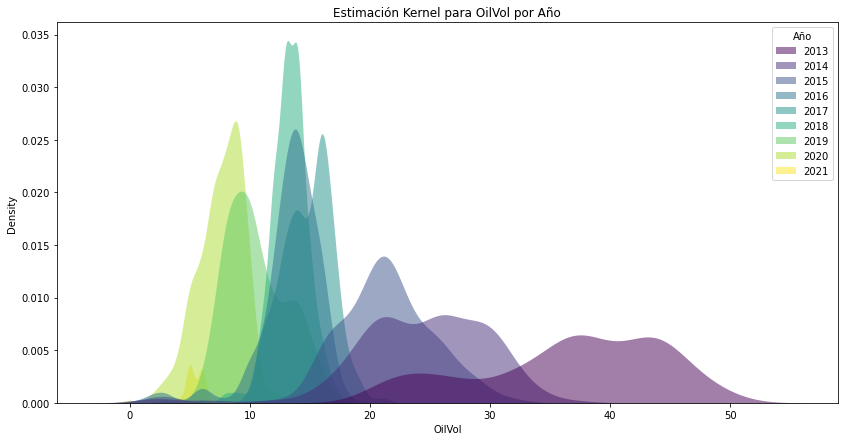

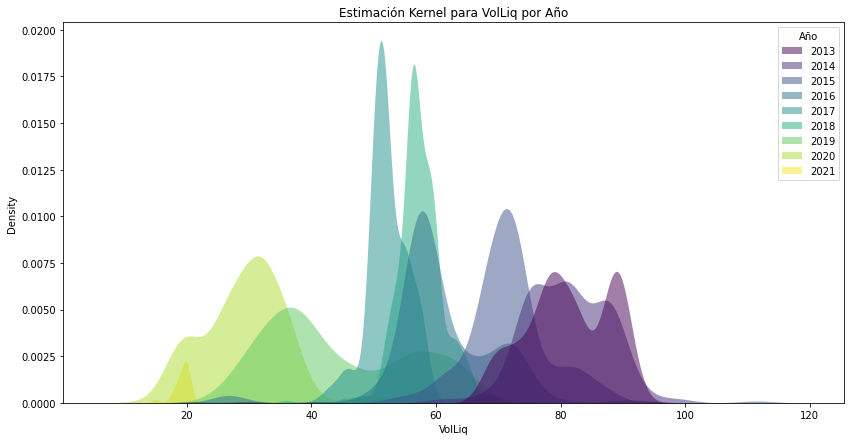

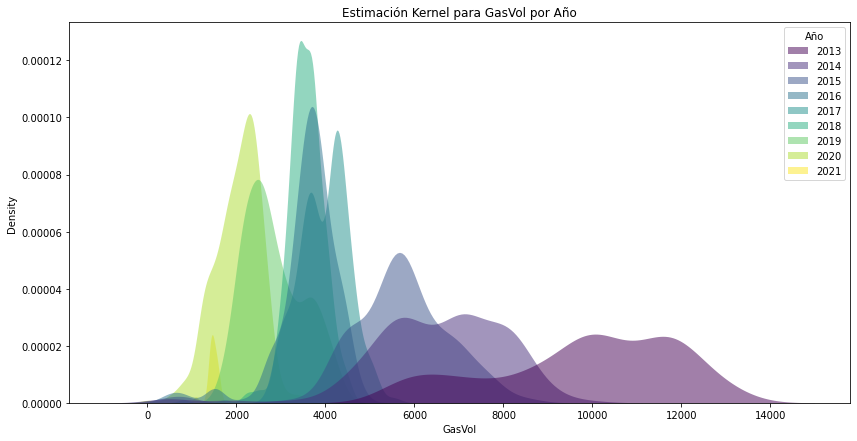

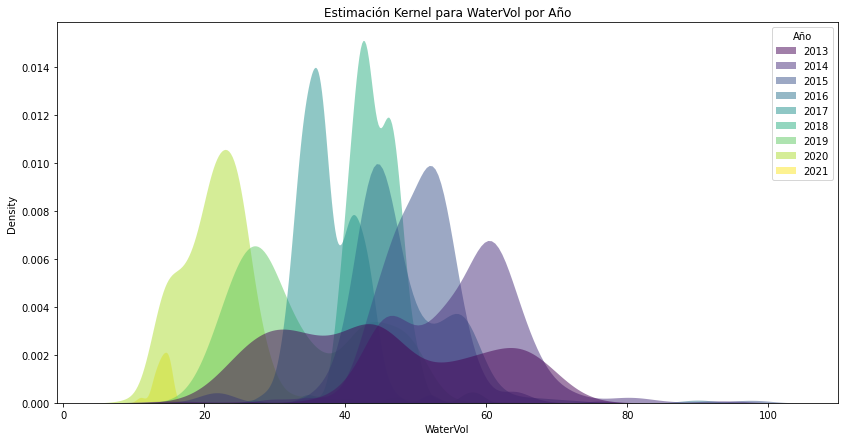

In [56]:
datos2['Año'] = datos2['Fecha'].dt.year

lista_2_plot = ['OilVol', 'VolLiq', 'GasVol', 'WaterVol']
for variable in lista_2_plot:
    fig, ax = plt.subplots(figsize=(14, 7))
    sns.kdeplot(data=datos2, x=variable, hue='Año', fill=True, alpha=0.5, linewidth=0, palette='viridis')
    ax.set_title(f'Estimación Kernel para {variable} por Año')
    plt.show()

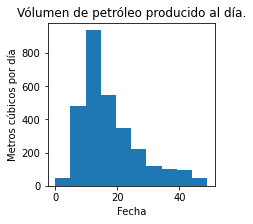

In [57]:
rcParams['figure.figsize'] = 3, 3
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

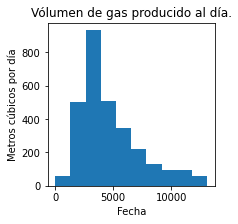

In [58]:
plt.hist(datos['GasVol'])
plt.title('Vólumen de gas producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

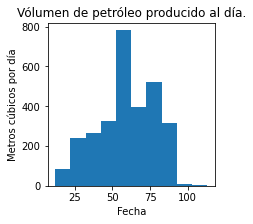

In [59]:
plt.hist(datos['VolLiq'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

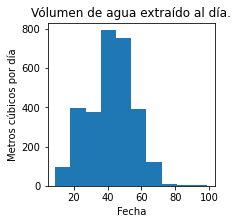

In [60]:
plt.hist(datos['WaterVol'])
plt.title('Vólumen de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

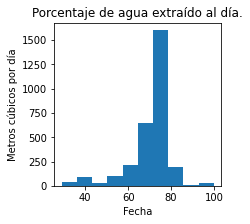

In [61]:
plt.hist(datos['WaterCut'])
plt.title('Porcentaje de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

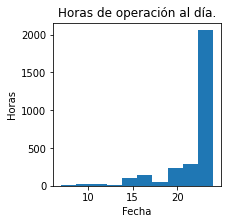

In [62]:
plt.hist(datos['WorkHours'])
plt.title('Horas de operación al día.')
plt.xlabel('Fecha')
plt.ylabel('Horas')
plt.show()
#

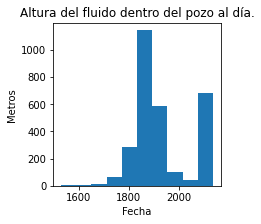

In [63]:
plt.hist(datos['DnmcLvl'])
plt.title('Altura del fluido dentro del pozo al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros')
plt.show()

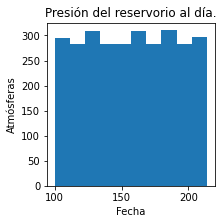

In [64]:
plt.hist(datos['Pressure'])
plt.title('Presión del reservorio al día.')
plt.xlabel('Fecha')
plt.ylabel('Atmósferas')
plt.show()

# Funciones

## Periodograma

Esta función sirve para detectar el período de una posible componente estacional determinística

In [65]:
# Función periodograma
def periodograma(serie, frecuencia = 70):
    """Serie : Introduzcar un objeto tipo series de pandas
        frecuencia(opcional): introduzca el número de indices de frecuencia que desea ver en el eje x (70 por defecto)"""
    f, Pxx_den=sp.signal.periodogram(serie)
    plt.plot(f[0:frecuencia], Pxx_den[0:frecuencia])
    for i in range(4):
        indice=np.argmax(Pxx_den, axis=0)
        print(f'El valor máximo no. {i+1} en el que se maximiza el periodograma es en el indice {indice} ')
        frecuencia_max=f[indice]
        print(f'La frecuencia es: x={frecuencia_max} con valor de periodograma y={Pxx_den[indice]} ')
        print(f'El período es: {1/frecuencia_max} días')
        print(f'Lo cual corresponde a {round(1/frecuencia_max / 30,3)} meses\n')
        f=np.delete(f,indice)
        Pxx_den=np.delete(Pxx_den,indice)
        plt.axvline(x=frecuencia_max,color='red')
    plt.show()
    return 
    

## Ajuste tendencia vía Kernel

In [66]:
def TendKer(serie,ancho):
    """Esta función ajusta una regresión Kernel a la serie en función del tiempo y la gráfica.
    La regresión usa un Kernel Gaussiano y la regresión es de tipo local.
    Además obtiene la serie sin la tendencia ajustada
        serie: Objeto tipo series de pandas,
        ancho: Ajusta el ancho de banda de la regresión, a mayor ancho menos suavidad"""
    from statsmodels.nonparametric.kernel_regression import KernelReg
    
    n = serie.shape[0]
    kde = KernelReg(endog=serie, exog=np.arange(n), var_type='c', bw=[ancho],reg_type='lc',ckertype='gaussian')
    
    estimator = kde.fit(np.arange(n))
    estimator = np.reshape(estimator[0],n)
    plt.plot(serie)
    plt.plot(serie.index, estimator, color = 'red')
    plt.title(f'Estimación Kernel de {serie.name} con bw= {ancho}')
    NoTendserie = serie - estimator
    return NoTendserie



## Ajuste de tendencia vía LOWESS

In [67]:
def TendLOWESS (serie, prop):
    """Esta función ajusta una regresión LOWESS no robusta a la serie.
    Además obtiene la serie sin la tendencia ajustada.
        serie: Objeto tipo series de pandas
        prop: Proporción de punto que se usarán para la estimación local, a mayor proporción menos suavidad"""
    from statsmodels.nonparametric.smoothers_lowess import lowess
    n = serie.shape[0]
    lowess_serie = lowess(serie, exog= np.arange(n), is_sorted=True, frac=prop, it=0)
    # lowess obtiene una matriz; la primera columna hace referencia al índice en flotante, y la segunda a la estimación 
    y = list(zip(*lowess_serie))[1]
    NoTendserie = serie - y
    # Gráficos
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación LOWESS de {serie.name} con frac = {prop}')
    return NoTendserie
    

## Ajuste tendencia promedios móviles

In [68]:
def TendMA(serie):
    ####Descomposición usando filtros
    from statsmodels.tsa.seasonal import seasonal_decompose
    from matplotlib import pyplot
    
    ###También se puede hacer vía STL###
    # Descomponer la serie de tiempo con un periodo de 365 días (para estacionalidad anual)
    result = seasonal_decompose(serie, model='additive', extrapolate_trend=6, period=365)
    
    # Graficar los resultados de la descomposición
    # desc_OilVol = result.plot()
    # pyplot.sho
    y = result.trend
    NoTendserie = serie - y
    # Gráfico
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación MA de {serie.name} de forma aditiva')
    return NoTendserie

# Análisis descriptivo de las series

## Volumen de petróleo

In [69]:
OilVol = datos['OilVol']

In [70]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=datos['OilVol'])])
fig.update_layout(title_text="Vólumen de petróleo producido al día.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


### Ajuste tendencia  

Se puede ver que la serie presenta una componente de tendencia, en particular es decreciente y tiene sentido en el contexto en que estamos.

#### Promedios móviles

In [71]:
rcParams['figure.figsize'] = 15, 10

Vamos a usar la componente de tendencia que se estima por medio del filtro de promedios móviles.

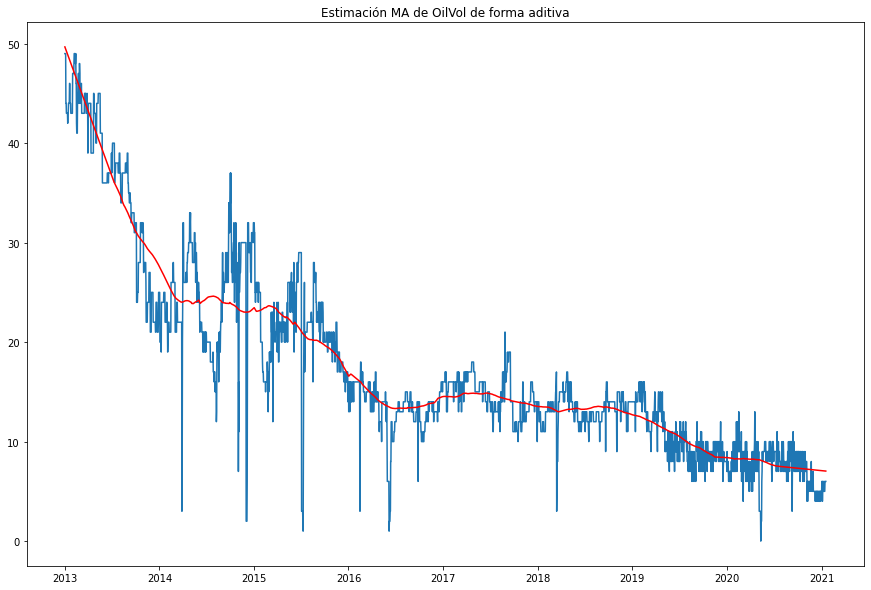

In [72]:
NoTen_OilVol_MA = TendMA(OilVol)

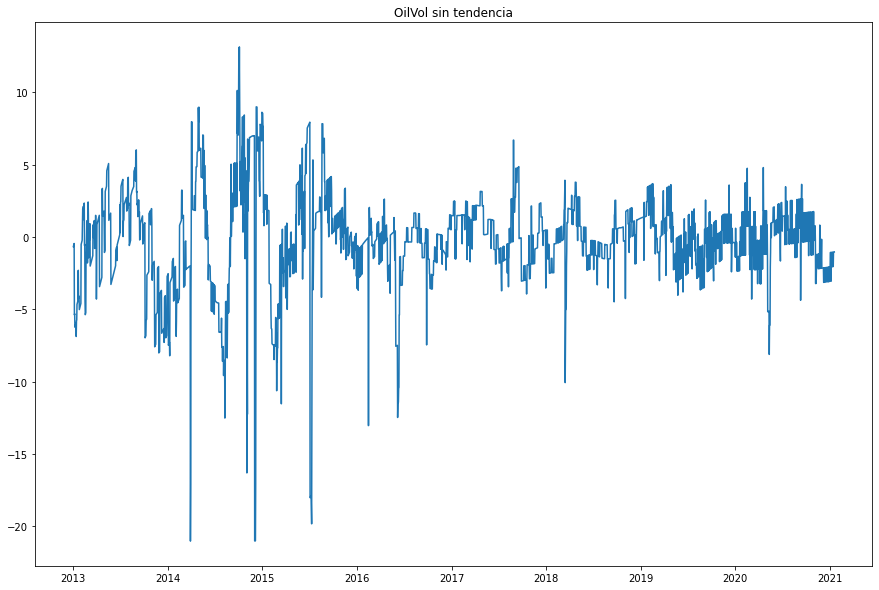

In [73]:
# Serie sin tendencia
plt.plot(NoTen_OilVol_MA)
plt.title('OilVol sin tendencia')
plt.show()

#### Kernel

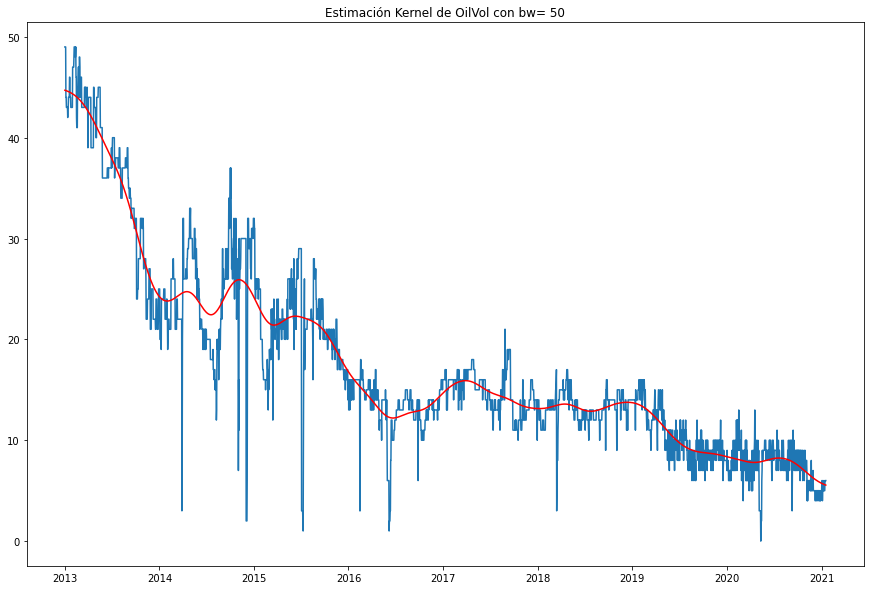

In [74]:
NoTen_OilVol_Kernel = TendKer(OilVol,ancho=50)

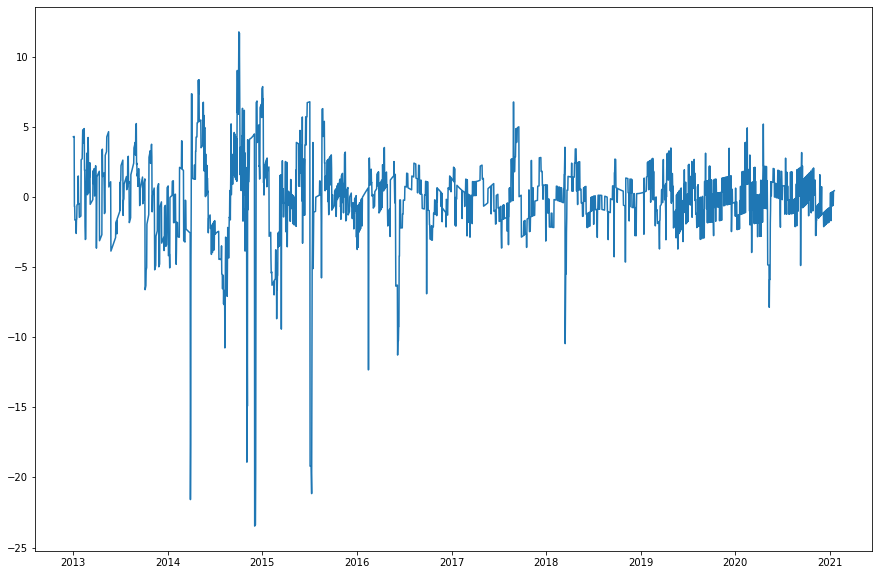

In [75]:
plt.plot(NoTen_OilVol_Kernel)

#### LOWESS

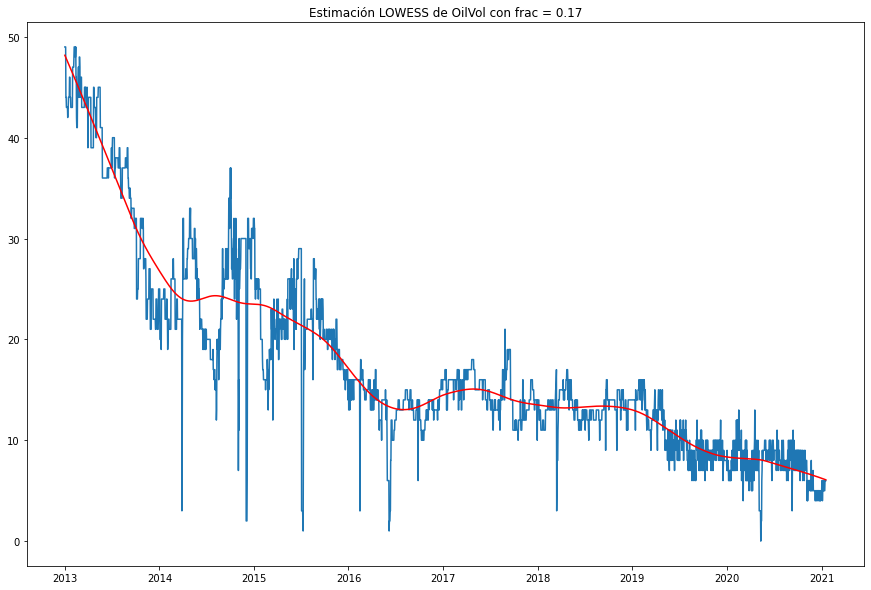

In [76]:
NoTen_OilVol_LOWESS = TendLOWESS(OilVol,prop=0.17)

### Detección estacionalidad

Se hará uso del periodograma y la función de autocorrelación para determinar si existe alguna componente estacional.

Se usará la serie sin tendencia ajustada vía Kernel, pues es la que mejor estabiliza la seria para identificar los rezagos más significativos.

El valor máximo no. 1 en el que se maximiza el periodograma es en el indice 25 
La frecuencia es: x=0.008506294658046955 con valor de periodograma y=908.3334156358067 
El período es: 117.56 días
Lo cual corresponde a 3.919 meses

El valor máximo no. 2 en el que se maximiza el periodograma es en el indice 14 
La frecuencia es: x=0.004763525008506295 con valor de periodograma y=745.954057591793 
El período es: 209.92857142857142 días
Lo cual corresponde a 6.998 meses

El valor máximo no. 3 en el que se maximiza el periodograma es en el indice 34 
La frecuencia es: x=0.012249064307587614 con valor de periodograma y=684.6774560500907 
El período es: 81.6388888888889 días
Lo cual corresponde a 2.721 meses

El valor máximo no. 4 en el que se maximiza el periodograma es en el indice 23 
La frecuencia es: x=0.008166042871725076 con valor de periodograma y=613.6577448064241 
El período es: 122.45833333333334 días
Lo cual corresponde a 4.082 meses



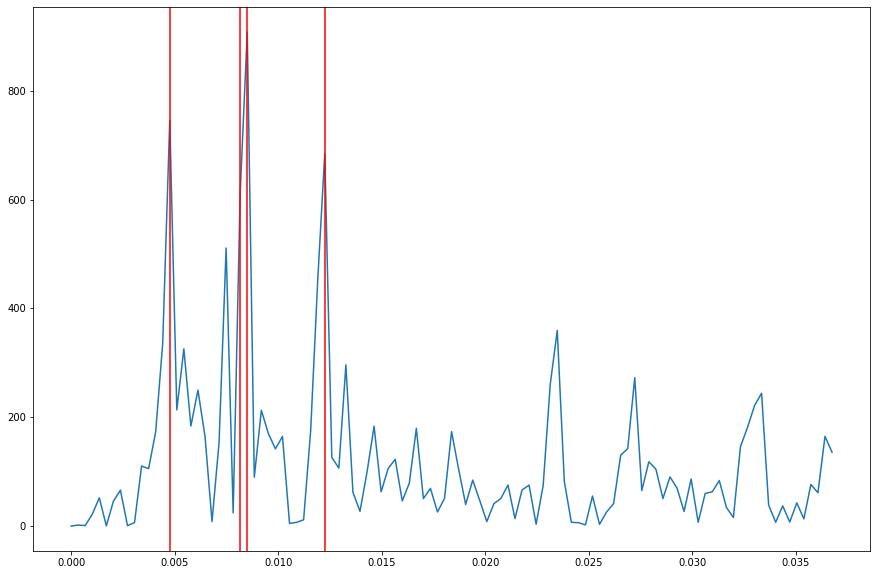

In [77]:
periodograma(NoTen_OilVol_Kernel, 109)

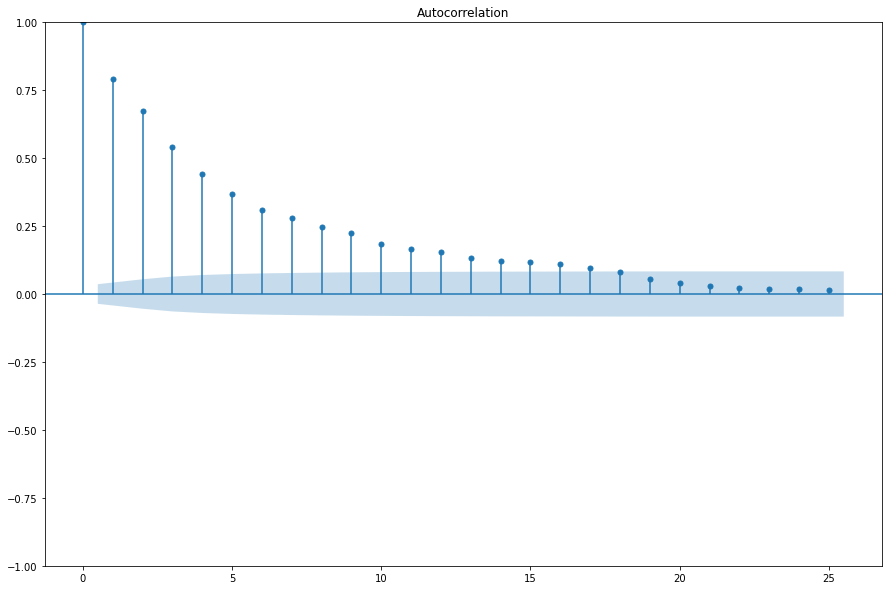

In [78]:
plot_acf(NoTen_OilVol_Kernel, lags=25)
plt.show()

Se tomarán 17 retardos de la variable para hacer la predicción de un año en una red neuronal

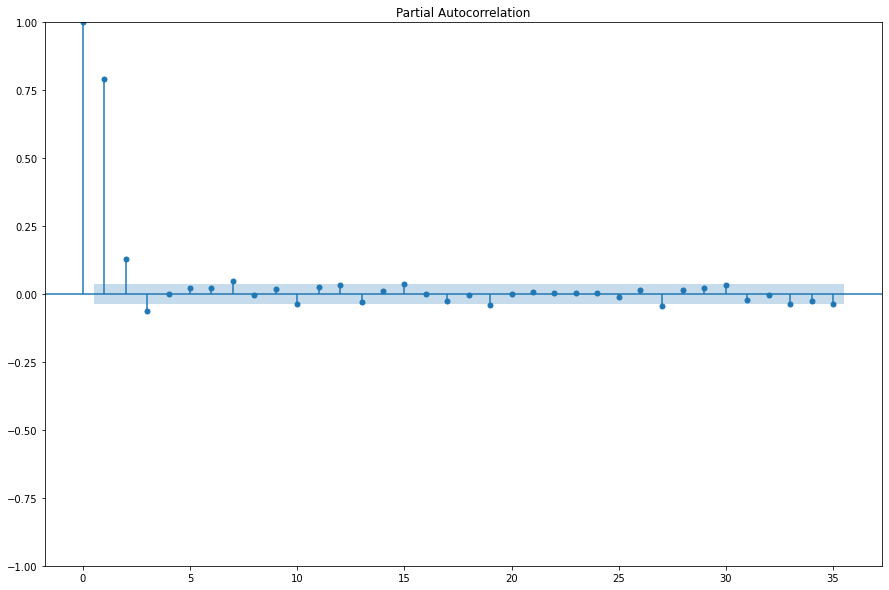

In [79]:
plot_pacf(NoTen_OilVol_Kernel)
plt.show()

La primera autocorrelación parcial es muy cercana a 1, lo cual sugiera presencia de raíz unitaria

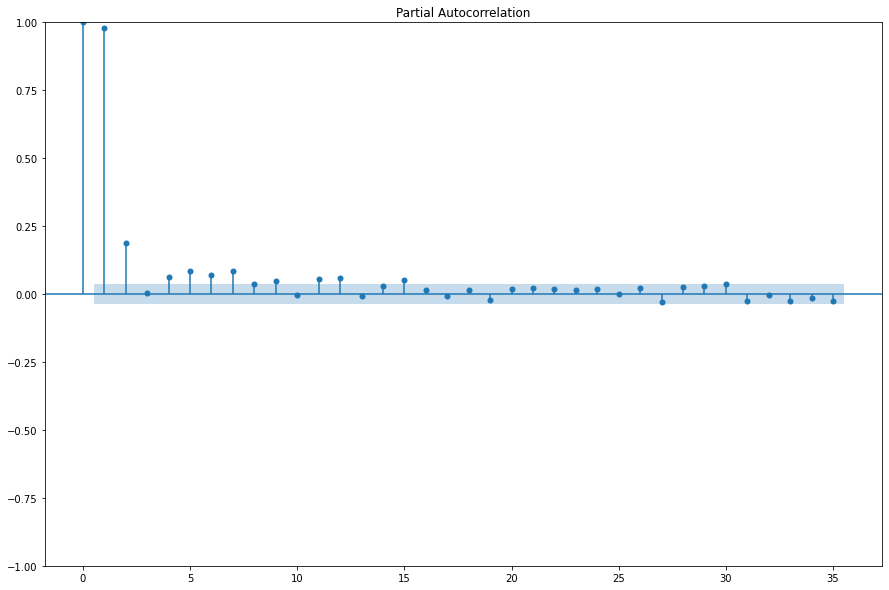

In [80]:
plot_pacf(OilVol)
plt.show()

In [81]:
from statsmodels.tsa.stattools import adfuller

### Modelado ARIMA

Dado que la serie no tiene una componente estacional, pero si la componente de tendencia entonces vamos a ajuster un modelo ARIMA. 

Con base a la función de autocorrelación parcial de la serie sin diferenciar, vemos que el primer rezago tiene una correlación muy alta, lo cual sugiere la presencia de raíz unitaria. Se confirmará en la celda siguiente.

Primero vamos a realizar la prueba de presencia de raíz unitaria de Dickey y Fuller. 
Se considerarán los primeros 14 rezagos y una regresión con drift.

In [82]:
adf = adfuller(OilVol,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -2.806503
P-value: 0.057351
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     21.84
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           2.67e-57
Time:                        21:26:23   Log-Likelihood:                -5776.7
No. Observations:                2924   AIC:                         1.159e+04
Df Residuals:                    2908   BIC:                         1.168e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0097      0.003     -2.807      0.005      -0.017      -0.003
x2            -0.2581      0.019    -13.846      0.000      -0.295      -0.222
x3            -0.0750      0.019     -3.902      0.000      -0.113      -0.037
x4            -0.1384      0.019     -7.188      0.000      -0.176      -0.101
x5            -0.1433      0.019     -7.404      0.000      -0.181      -0.105
x6            -0.1374      0.019     -7.070      0.000      -0.176      -0.099
x7            -0.1412      0.020     -7.210      0.000      -0.180      -0.103
x8            -0.0911      0.020     -4.628      0.000      -0.130      -0.052
x9            -0.0910      0.020     -4.625      0.000      -0.130      -0.052
x10           -0.0427      0.020     -2.187      0.029      -0.081      -0.004
x11           -0.0998      0.019     -5.152      0.000      -0.138      -0.062
x12           -0.0828      0.019     -4.306      0.000      -0.121      -0.045
x13           -0.0204      0.019     -1.067      0.286      -0.058       0.017
x14           -0.0613      0.019     -3.214      0.001      -0.099      -0.024
x15           -0.0667      0.018     -3.611      0.000      -0.103      -0.030
const          0.1381      0.069      2.002      0.045       0.003       0.273
==============================================================================
Omnibus:                     2295.216   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353186.598
Skew:                          -2.902   Prob(JB):                         0.00
Kurtosis:                      56.528   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [83]:
OilVold = OilVol.diff()
OilVold.dropna(inplace=True)

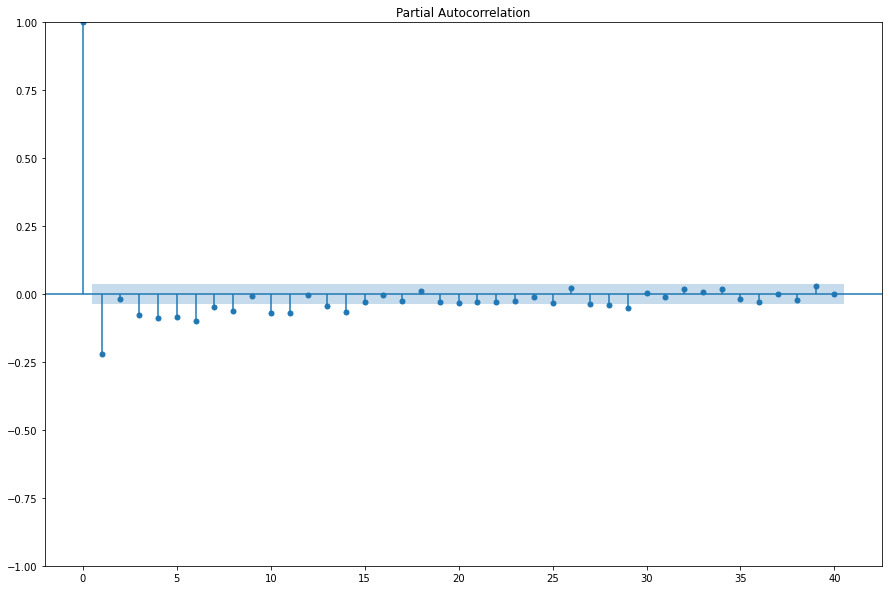

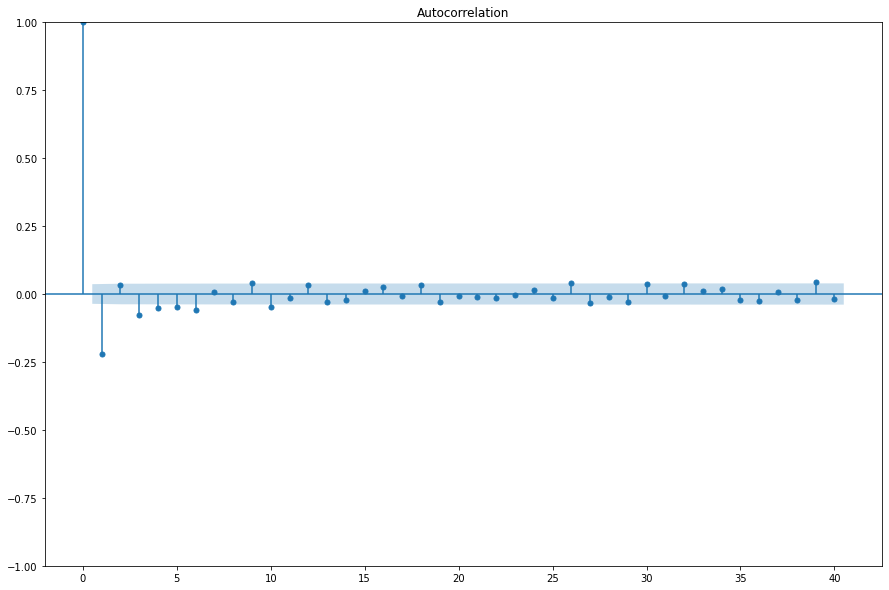

In [84]:
plot_pacf(OilVold, lags=40)
plot_acf(OilVold, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [85]:
adf = adfuller(OilVold,maxlag=15,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=15,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -18.596479
P-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     20.62
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           4.50e-57
Time:                        21:27:07   Log-Likelihood:                -5774.1
No. Observations:                2923   AIC:                         1.158e+04
Df Residuals:                    2906   BIC:                         1.168e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0096      0.003     -2.776      0.006      -0.016      -0.003
x2            -0.2601      0.019    -13.918      0.000      -0.297      -0.223
x3            -0.0768      0.019     -3.989      0.000      -0.115      -0.039
x4            -0.1391      0.019     -7.222      0.000      -0.177      -0.101
x5            -0.1457      0.019     -7.502      0.000      -0.184      -0.108
x6            -0.1403      0.020     -7.183      0.000      -0.179      -0.102
x7            -0.1425      0.020     -7.270      0.000      -0.181      -0.104
x8            -0.0937      0.020     -4.745      0.000      -0.132      -0.055
x9            -0.0936      0.020     -4.741      0.000      -0.132      -0.055
x10           -0.0468      0.020     -2.372      0.018      -0.086      -0.008
x11           -0.1038      0.020     -5.307      0.000      -0.142      -0.065
x12           -0.0870      0.019     -4.467      0.000      -0.125      -0.049
x13           -0.0244      0.019     -1.264      0.206      -0.062       0.013
x14           -0.0635      0.019     -3.322      0.001      -0.101      -0.026
x15           -0.0740      0.019     -3.877      0.000      -0.111      -0.037
x16           -0.0279      0.018     -1.510      0.131      -0.064       0.008
const          0.1355      0.069      1.962      0.050    9.29e-05       0.271
==============================================================================
Omnibus:                     2303.789   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           354902.699
Skew:                          -2.922   Prob(JB):                         0.00
Kurtosis:                      56.664   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=13**

In [86]:
from pmdarima.arima import auto_arima

In [87]:
auto_OilVol = auto_arima(OilVold,start_p=0,d=0, start_q= 0, max_p=15, max_q=13, max_order=15,
                         seasonal=False,information_criterion='aic')

In [93]:
auto_OilVol.order

(3, 0, 1)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(3,1). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [94]:
import statsmodels.api as smapi
OilVolARIMA = smapi.tsa.SARIMAX(OilVol,order=(3,1,1),trend='c')

In [95]:
ajusteOilVol = OilVolARIMA.fit()

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Realizamos la predicción a un año con un intervalo de predicción al 95% 

In [90]:
salforecast=ajusteOilVol.get_forecast(steps=365)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticos=salforecast.predicted_mean
print(pronosticos)
print(ICforecast95)

2021-01-18    5.799190
2021-01-19    5.661176
2021-01-20    5.532633
2021-01-21    5.435738
2021-01-22    5.356885
                ...   
2022-01-13    0.209851
2022-01-14    0.195948
2022-01-15    0.182045
2022-01-16    0.168143
2022-01-17    0.154240
Freq: D, Name: predicted_mean, Length: 365, dtype: float64
            lower OilVol  upper OilVol
2021-01-18      2.375979      9.222401
2021-01-19      1.429556      9.892796
2021-01-20      0.659573     10.405692
2021-01-21      0.183401     10.688075
2021-01-22     -0.167443     10.881213
...                  ...           ...
2022-01-13    -15.931907     16.351609
2022-01-14    -15.965333     16.357230
2022-01-15    -15.998736     16.362827
2022-01-16    -16.032115     16.368401
2022-01-17    -16.065471     16.373951

[365 rows x 2 columns]


In [91]:
history[-30:]

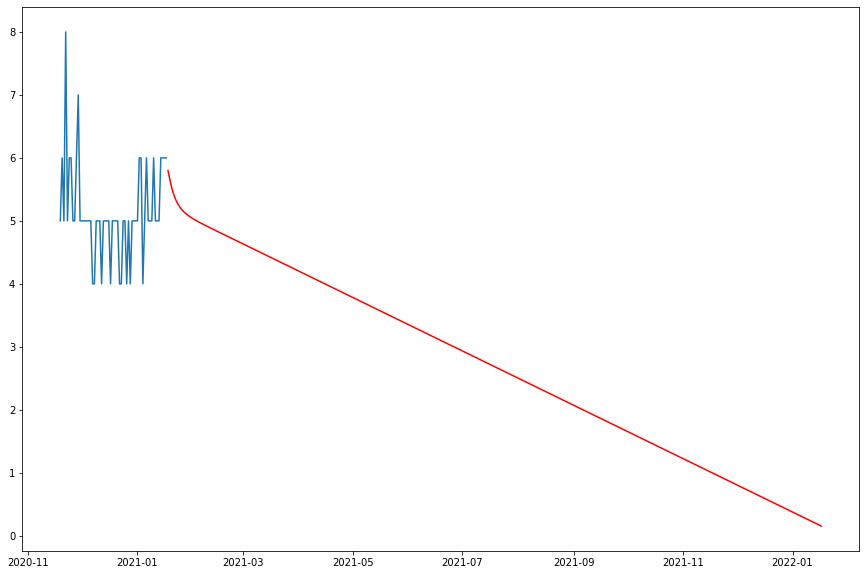

In [92]:
plt.plot(OilVol[-60:])
plt.plot(pronosticos, color='red')

Predicción=0.186409, Esperado=0.000000
Predicción=0.007625, Esperado=-2.000000
Predicción=0.409192, Esperado=1.000000
Predicción=-0.029179, Esperado=-2.000000
Predicción=0.647913, Esperado=2.000000
Predicción=-0.093905, Esperado=0.000000
Predicción=0.292690, Esperado=2.000000
Predicción=-0.298050, Esperado=-2.000000
Predicción=0.338762, Esperado=3.000000
Predicción=-0.675180, Esperado=-3.000000
Predicción=0.474642, Esperado=0.000000
Predicción=-0.140315, Esperado=2.000000
Predicción=-0.281633, Esperado=-2.000000
Predicción=0.361151, Esperado=2.000000
Predicción=-0.457866, Esperado=-3.000000
Predicción=0.575899, Esperado=2.000000
Predicción=-0.375049, Esperado=-1.000000
Predicción=0.334610, Esperado=0.000000
Predicción=0.029528, Esperado=-1.000000
Predicción=0.319019, Esperado=0.000000
Predicción=0.186818, Esperado=2.000000
Predicción=-0.150432, Esperado=0.000000
Predicción=0.081243, Esperado=-2.000000


C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Predicción=0.315289, Esperado=0.000000
Predicción=0.073604, Esperado=4.000000
Predicción=-0.583055, Esperado=-2.000000
Predicción=0.305955, Esperado=2.000000
Predicción=-0.686404, Esperado=-2.000000
Predicción=0.165123, Esperado=1.000000
Predicción=-0.447316, Esperado=-1.000000
Predicción=0.072539, Esperado=0.000000
Predicción=-0.130102, Esperado=-1.000000
Predicción=0.171469, Esperado=2.000000
Predicción=-0.366959, Esperado=-2.000000
Predicción=0.383811, Esperado=0.000000
Predicción=-0.038990, Esperado=2.000000
Predicción=-0.280372, Esperado=-1.000000
Predicción=0.170591, Esperado=2.000000
Predicción=-0.540607, Esperado=-4.000000
Predicción=0.643216, Esperado=3.000000
Predicción=-0.659387, Esperado=-1.000000
Predicción=0.287317, Esperado=0.000000
Predicción=-0.107507, Esperado=1.000000
Predicción=-0.223933, Esperado=-1.000000
Predicción=0.116421, Esperado=0.000000
Predicción=-0.093167, Esperado=1.000000
Predicción=-0.210827, Esperado=1.000000
Predicción=-0.291792, Esperado=-2.000000
P

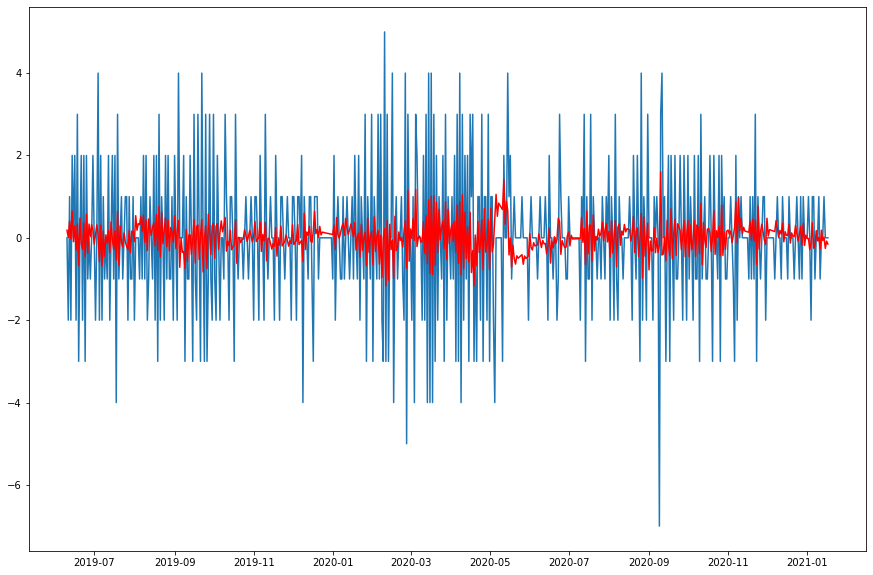

In [322]:
## Rolling
from sklearn.metrics import mean_squared_error

X = OilVold
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predicciones = list()
for t in range(len(test)):
	modelo = smapi.tsa.statespace.SARIMAX(history, trend='n', order=(3,0,1))
	modelo_fit = modelo.fit(disp=0)
	output = modelo_fit.forecast()
	yhat = output[0]
	predicciones.append(yhat)
	obs = test[t]
	history.append(obs)
	print('Predicción=%f, Esperado=%f' % (yhat, obs))
error = mean_squared_error(test, predicciones)
print('ECM: %.3f' % error)

# plot
predicciones=pd.Series(predicciones,index=test.index)

plt.plot(test)
plt.plot(predicciones, color='red')
plt.show()

In [55]:
print(ajusteOilVol.summary())

                               SARIMAX Results                                
Dep. Variable:                 OilVol   No. Observations:                 2939
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -5807.267
Date:                Mon, 28 Oct 2024   AIC                          11626.534
Time:                        18:13:31   BIC                          11662.447
Sample:                    01-01-2013   HQIC                         11639.465
                         - 01-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0036      0.002     -1.458      0.145      -0.008       0.001
ar.L1          0.7420      0.019     39.340      0.000       0.705       0.779
ma.L1         -1.0163      0.021    -48.396      0.0

## Volumen líquido

In [56]:
VolLiq = datos['VolLiq']

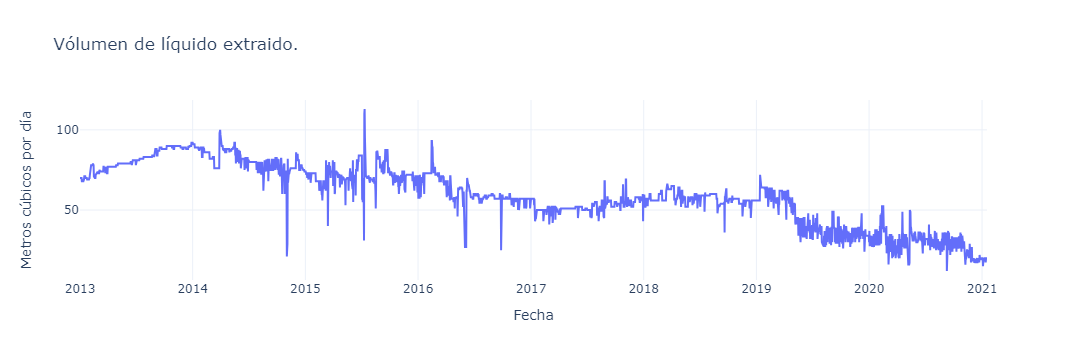

In [58]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=datos['VolLiq'])])
fig.update_layout(title_text="Vólumen de líquido extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


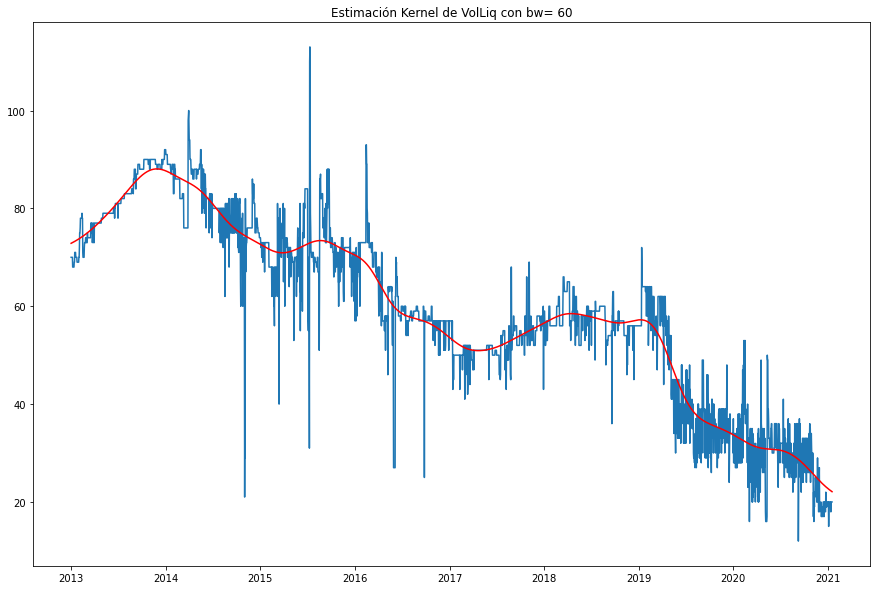

In [67]:
NoTen_VolLiq = TendKer(VolLiq, ancho=60)

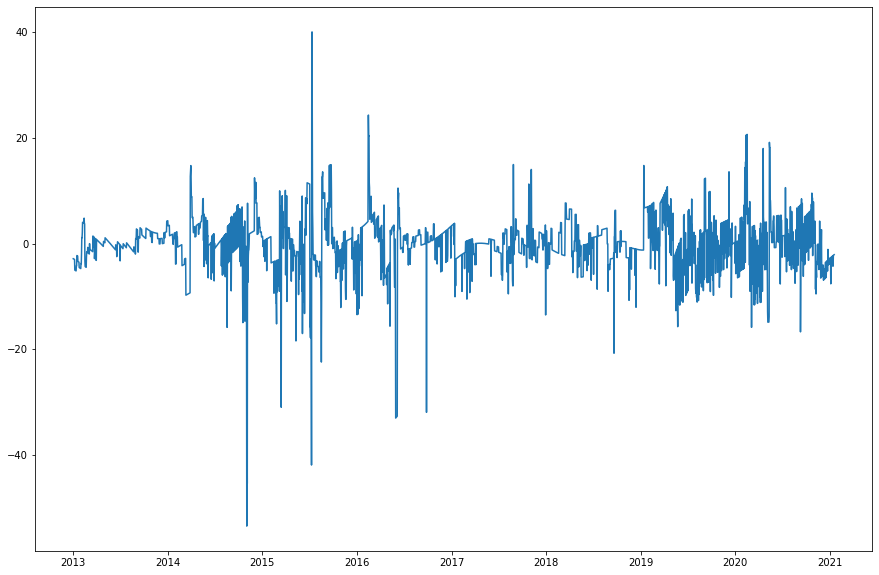

In [68]:
plt.plot(NoTen_VolLiq)

In [ ]:
plot_pacf(NoTen_VolLiq)
plot_acf(NoTen_VolLiq)
plt.show()

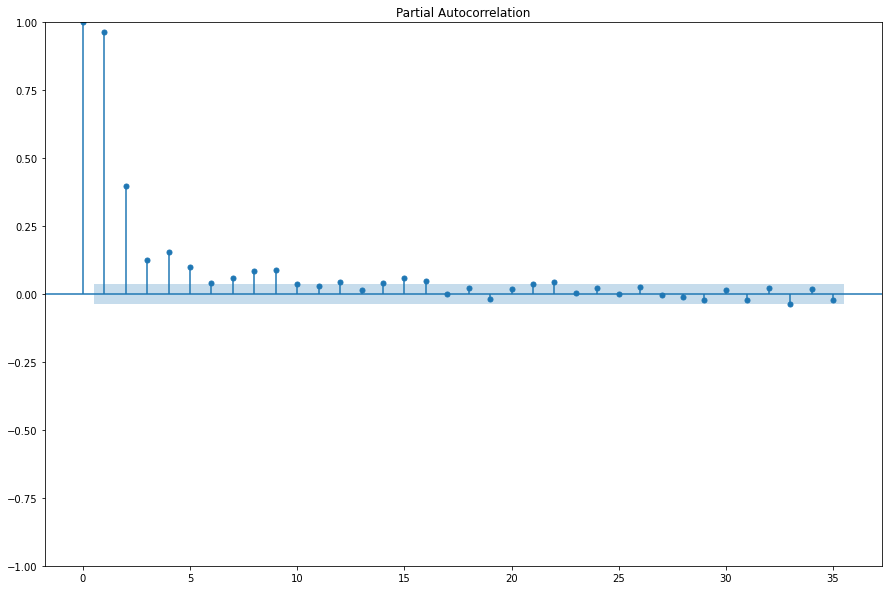

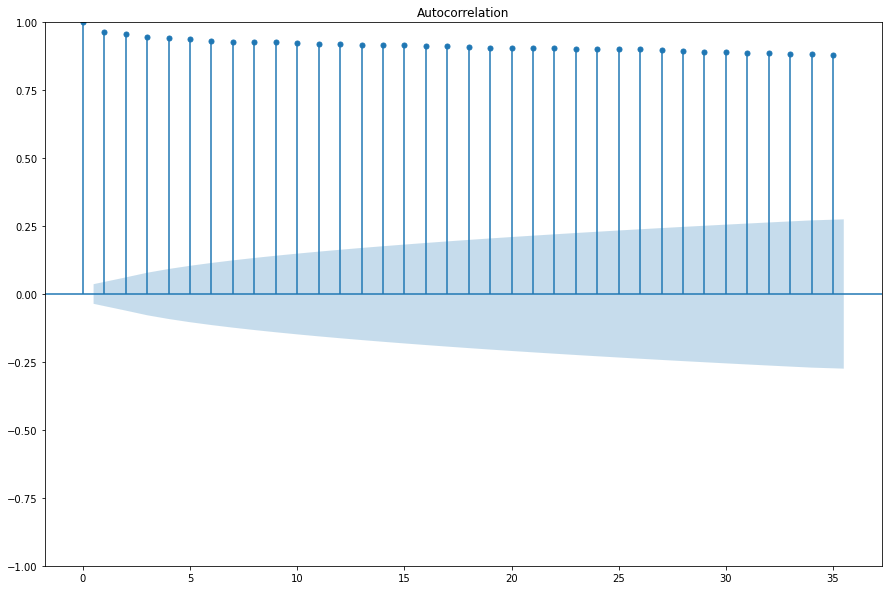

In [59]:
plot_pacf(VolLiq)
plot_acf(VolLiq)
plt.show()

### Modelo ARIMA

## Volumen de gas producido

## Volumen de agua extraida

## Porcentaje de agua en líquido

## Horas de operación

## Altura del fluido

## Presión

In [1]:
import numpy as np
import scipy as sp

import statsmodels as sm
import matplotlib.pylab as plt
import pandas as pd
import statsmodels.api as smapi

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math





In [2]:
from statsmodels.tsa.stattools import adfuller
